In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xa
import lib.utilities as utl

def tpot_from_N(Tb,N,z,dz):
	g0=9.80665
	tpot = Tb*np.exp((N**2/g0)*(z+dz))
	return tpot

def tpot_from_dth(Tb,dth,z):
    dth_arr = np.arange(1.,len(z)+1,1.)
    return Tb+dth_arr*dth

# calculate density when pressure and potential temperature are given
# uses ideal gas equation
def rho_ideal_gas(p,th):
    RS  = 287.058 # specific gas constant in  J/kgK
    t   = t_from_tpot(th,p)
    rho = p/(RS*t)
    
    return rho

def deltap(rho,deltaz):
    
    if deltaz == 0:
        dp = 0
    else:
        dp = -rho*deltaz*9.81 
    
    return dp

def calculate_saturation_pressures(t):
	#result = 611.21 * 10**((7.5*t)/(t+237.3))
	result = 610.8*np.exp(17.27*t/(t+237.3)) # in Pa, t in deg. C
	return result

def calculate_qv_from_rh(rh,prs_sat,prs):
	c_Rwv  = 	461.5 # J/kgK spec. gas constant for water vapor
	c_Rair =	286.9 # J/kgK spec. gas constant for dry air
	result = rh/100.0 * ((c_Rair/c_Rwv)*(prs_sat/prs))
	return result

def t_from_tpot(tpot,p):
	t = tpot/((10.0**5.0/p)**(2.0/7.0))
	return t


def barometric_formula(h):
	M=0.0289644		# molar mass of air, kg/mol
	g0=9.80665		# gravitational acceleration m/s^2
	R=8.3144598		# universal gas constant, J/(mol*K)

	if 0<= h and h < 11000:
		Tb = 288.15
		Lb = -0.0065
		Pb = 101325.0
		hb = 0.0
		b=0
	elif 11000 <= h and h < 20000:
		Tb = 216.65
		Lb = 0.000001
		Pb = 22632.10
		hb = 11000.0
		b=1
	elif 20000 <= h and h < 32000:
		Tb = 216.65
		Lb = 0.001
		Pb = 5474.89
		hb = 20000.0
		b=2
	elif 32000 <= h and h < 47000:
		Tb = 228.65
		Lb = 0.0028
		Pb = 868.02
		hb = 32000.0
		b=3
	elif 47000 <= h and h < 51000:
		Tb = 270.65
		Lb = 0.000001
		Pb = 110.91
		hb = 47000.0
		b=4
	elif 51000 <= h and h < 71000:
		Tb = 270.65
		Lb = -0.0028
		Pb = 66.94
		hb = 51000.0
		b=5
	else:
		Tb = 214.65
		Lb = -0.002
		Pb = 3.96
		hb = 70000.0
		b=6

	P = Pb*(Tb/(Tb+Lb*(h-hb)))**(g0*M/(R*Lb))		# as seen in, e.g. https://en.wikipedia.org/wiki/Barometric_formula
	return P

def p_from_th(p0,z_arr,th_arr):
    p_arr = np.zeros(len(z_arr))
    
    for n, z in enumerate(z_arr):

        if n == 0:
            pm1 = p0
            dz  = 0
        else:
            pm1 = p_arr[n-1]
            dz  = z_arr[n]-z_arr[n-1]

        rho      = rho_ideal_gas(pm1,th_arr[n])
        p_arr[n] = pm1+deltap(rho=rho,deltaz=dz)

    return p_arr

# Generate a WRF sounding

/usr/lib/python3/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


vertical wavelength: 12566
dimensionless inverse mountain height: 2.00


"\nfh = open(outfile,'w')\nfh.write('{:10.2f}{:12.2f}{:12.2e}\n'.format(p_arr[0]/100,Tb,qv))\nfor n in range(Nz):\n    fh.write('{:10.2f}{:12.2f}{:12.2e}{:12.2f}{:12.2f}\n'.format(z_arr[n],th_arr[n],qv_arr[n],u_arr[n],v_arr[n]))\nprint('wrote '+outfile)\n"

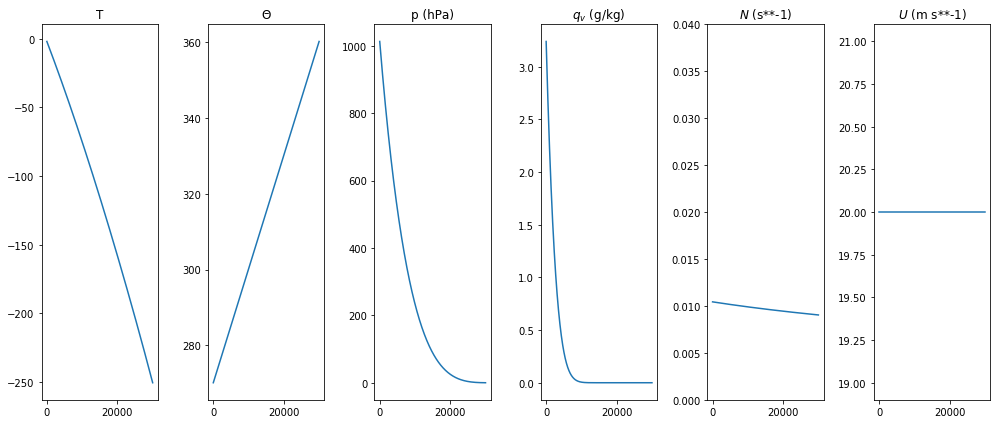

In [3]:
# set parameters
N  = 0.01
ws = 20.0
Tb = 270
p0  = 101325  #hPa surface pressure
zmax = 30000
dz   = 50.0
rh   = 100.
rhtop=30000

z_arr  = np.arange(0,zmax+dz,dz)
Nz     = len(z_arr)
th_arr = tpot_from_dth(Tb,0.15,z_arr)# tpot_from_N(Tb,N,z_arr,dz) 
qv_arr = z_arr*0
u_arr  = np.ones(Nz)*ws
v_arr  = np.zeros(Nz)
p_arr  = np.zeros(Nz)
N_arr  = np.zeros(Nz-1)

p_arr  = p_from_th(p0=p0,z_arr=z_arr,th_arr=th_arr)
for n, z in enumerate(z_arr):
    if n < len(z_arr)-1:
        N_arr[n]  = np.sqrt(9.81*(np.log(th_arr[n+1])-np.log(th_arr[n]))/(z_arr[n+1]-z_arr[n]))
t_arr    = t_from_tpot(th_arr,p_arr)
psat_arr = calculate_saturation_pressures(t_arr-273.15)
qv_arr   = calculate_qv_from_rh(rh,psat_arr,p_arr)*1000. # wrf wants it in g/kg
qv_arr[np.isinf(qv_arr)]=0.0 # remove potential infinities

print('vertical wavelength: {:4.0f}'.format(2*np.pi*ws/N))
print('dimensionless inverse mountain height: {:1.2f}'.format(ws/(N*1000.)))


qv_arr[z_arr>=26000] = 0

if rhtop != 0:
    qv = qv_arr[0]+qv_arr[0]-qv_arr[1]
else:
    qv = 0

f, ax = plt.subplots(1,6,figsize=(14,6))
ax[0].plot(z_arr, t_arr-273.15)
ax[1].plot(z_arr, th_arr)
ax[2].plot(z_arr, p_arr/100)
ax[3].plot(z_arr, qv_arr)
ax[4].plot(z_arr[:-1], N_arr)
ax[5].plot(z_arr,u_arr)
           
ax[0].set_title('T')
ax[1].set_title('$\Theta$')
ax[2].set_title('p (hPa)')
ax[3].set_title('$q_v$ (g/kg)')
ax[4].set_title('$N$ (s**-1)')
ax[5].set_title('$U$ (m s**-1)')

ax[4].set_ylim(0,0.04)

plt.tight_layout()

# write the sounding to file
outfile='input_sounding_{:n}_{:n}_{:2.4f}_{:2.2f}'.format(Tb,ws,np.mean(N_arr),rh/100.)

'''
fh = open(outfile,'w')
fh.write('{:10.2f}{:12.2f}{:12.2e}\n'.format(p_arr[0]/100,Tb,qv))
for n in range(Nz):
    fh.write('{:10.2f}{:12.2f}{:12.2e}{:12.2f}{:12.2f}\n'.format(z_arr[n],th_arr[n],qv_arr[n],u_arr[n],v_arr[n]))
print('wrote '+outfile)
'''

# wrf sounding to icar input file
forcing resolution = icar resolution

In [4]:
def get_topo(x,topo='witch',a0=1000,a1=20000):
    if topo == 'witch':
        h=a0*(a1**2/(x**2+a1**2))				# topography
    elif topo == 'triangle':
        if np.abs(x) <= a1/2.0:
                k = np.sign(x)
                h = -np.sign(x)*x*2.0*(a0/a1)+a0
        else:
            h = 0.0
    elif topo=="sine":
        h=a0/2.0+a0/2.0*np.sin((np.pi/a1)*(x-a1/2.0))		# sine with the minimum at domain center
    return h

In [5]:
# set basic characteristics
nrz    = 10    # only use every nrz-th entry from above arrays (to preserve space)
dx     = 2000
ntime  = 6

nx     = 404   # use even numbers for now!
ny     = 50    # use even numbers for now!
nlvls  = len(z_arr[::nrz])

lonc   = 0.
latc   = 0.

# find degree extension by calling haversine until
# we find the angle that best approximates the distance
test_min=99999.0
angle = None


for test_llon in np.arange(0.0,90.0,0.001):
    test_result1 = utl.haversine(lonc-test_llon/2.0,latc,lonc+test_llon/2.0,latc)
    test_result2 = np.abs(test_result1 - dx)
    if  test_result2 < test_min:
        test_min = test_result2
        angle = test_llon
ddeg=angle

In [6]:
lons=np.arange(-nx/2,nx/2,1)*ddeg
lats=np.arange(-ny/2,ny/2,1)*ddeg
xs  =np.arange(-nx/2,nx/2,1)*dx
xx, xy = np.meshgrid(lons,lats)

In [7]:
# forcing data
time   = np.arange(0,ntime,1)
qvapor = np.zeros(ntime*nlvls*ny*nx).reshape(ntime,nlvls,ny,nx) # set
qcloud = np.zeros(ntime*nlvls*ny*nx).reshape(ntime,nlvls,ny,nx)
qice   = np.zeros(ntime*nlvls*ny*nx).reshape(ntime,nlvls,ny,nx)
u      = np.zeros(ntime*nlvls*ny*nx).reshape(ntime,nlvls,ny,nx) # set
v      = np.zeros(ntime*nlvls*ny*nx).reshape(ntime,nlvls,ny,nx)

t      = np.zeros(ntime*nlvls*ny*nx).reshape(ntime,nlvls,ny,nx) # set
tsk    = np.zeros(ntime*nlvls*ny*nx).reshape(ntime,nlvls,ny,nx)
pb     = np.zeros(ntime*nlvls*ny*nx).reshape(ntime,nlvls,ny,nx)
ph     = np.zeros(ntime*nlvls*ny*nx).reshape(ntime,nlvls,ny,nx) # set
p      = np.zeros(ntime*nlvls*ny*nx).reshape(ntime,nlvls,ny,nx) # set
phb    = np.zeros(ntime*nlvls*ny*nx).reshape(ntime,nlvls,ny,nx)

sp     = np.zeros(ntime*ny*nx).reshape(ntime,ny,nx) # set

xlong  = np.zeros(ntime*ny*nx).reshape(ntime,ny,nx) # set
xlat   = np.zeros(ntime*ny*nx).reshape(ntime,ny,nx) # set
hgt    = np.zeros(ntime*ny*nx).reshape(ntime,ny,nx) # should be zero for background

# ICAR data
xlong_m  = np.zeros(ny*nx).reshape(ny,nx) # set
xlat_m   = np.zeros(ny*nx).reshape(ny,nx) # set
hgt_m    = np.zeros(ny*nx).reshape(ny,nx) # set
landmask = np.zeros(ny*nx).reshape(ny,nx)

xlong_m = xx
xlat_m  = xy


for i in range(ntime):
    sp[i,:,:] = p_arr[0]
    xlong[i,:,:] = xx
    xlat[i,:,:] = xy
    for k in range(nx):
        hgt_m[:,k] = get_topo(x=xs[k],a0=1000.,a1=20000.,topo='witch')
        for j in range(ny):
            qvapor[i,:,j,k]   = qv_arr[::nrz]/1000.
            u[i,:,j,k]        = u_arr[::nrz]
            t[i,:,j,k]        = th_arr[::nrz]
            ph[i,:,j,k]       = z_arr[::nrz]
            p[i,:,j,k]        = p_arr[::nrz]

In [8]:
icar_input_ds	= xa.Dataset(
                        data_vars={
                            'HGT':(['Time','south_north','west_east'],hgt),
                            'XLONG':(['Time','south_north','west_east'],xlong),
                            'XLAT':(['Time','south_north','west_east'],xlat),
                            'P':(['Time','bottom_top','south_north','west_east'],p),
                            'T':(['Time','bottom_top','south_north','west_east'],t),
                            'PH':(['Time','bottom_top','south_north','west_east'],ph),
                            'U':(['Time','bottom_top','south_north','west_east'],u),
                            'V':(['Time','bottom_top','south_north','west_east'],v),
                            'sp':(['Time','south_north','west_east'],sp),
                            'PB':(['Time','bottom_top','south_north','west_east'],pb),
                            'PHB':(['Time','bottom_top','south_north','west_east'],phb),
                            'QVAPOR':(['Time','bottom_top','south_north','west_east'],qvapor),
                            'QCLOUD':(['Time','bottom_top','south_north','west_east'],qcloud),
                            'QICE':(['Time','bottom_top','south_north','west_east'],qice),
                            'TSK':(['Time','bottom_top','south_north','west_east'],tsk),
                            'HGT_M':(['south_north','west_east'],hgt_m),
                            'XLONG_M':(['south_north','west_east'],xlong_m),
                            'XLAT_M':(['south_north','west_east'],xlat_m),
                            'LANDMASK':(['south_north','west_east'],landmask)
                        },
                        coords={
                            'Time':time,
                            'bottom_top':np.arange(0,nlvls,1.0),
                            'south_north':np.arange(0,ny,1.0),
                            'west_east':np.arange(0,nx,1.0)
                        }
                    )

In [55]:
icar_input_ds.to_netcdf('./icarinput_{:s}.nc'.format(outfile),format='NETCDF4')

In [18]:
ofrc.XLAT

<xarray.DataArray 'XLAT' (Time: 5, south_north: 5, west_east: 11)>
array([[[-0.5 , -0.5 , ..., -0.5 , -0.5 ],
        [-0.25, -0.25, ..., -0.25, -0.25],
        ...,
        [ 0.25,  0.25, ...,  0.25,  0.25],
        [ 0.5 ,  0.5 , ...,  0.5 ,  0.5 ]],

       [[-0.5 , -0.5 , ..., -0.5 , -0.5 ],
        [-0.25, -0.25, ..., -0.25, -0.25],
        ...,
        [ 0.25,  0.25, ...,  0.25,  0.25],
        [ 0.5 ,  0.5 , ...,  0.5 ,  0.5 ]],

       ...,

       [[-0.5 , -0.5 , ..., -0.5 , -0.5 ],
        [-0.25, -0.25, ..., -0.25, -0.25],
        ...,
        [ 0.25,  0.25, ...,  0.25,  0.25],
        [ 0.5 ,  0.5 , ...,  0.5 ,  0.5 ]],

       [[-0.5 , -0.5 , ..., -0.5 , -0.5 ],
        [-0.25, -0.25, ..., -0.25, -0.25],
        ...,
        [ 0.25,  0.25, ...,  0.25,  0.25],
        [ 0.5 ,  0.5 , ...,  0.5 ,  0.5 ]]])
Coordinates:
  * south_north  (south_north) float64 0.0 1.0 2.0 3.0 4.0
  * west_east    (west_east) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
  * Time         (T

In [27]:
icar_input_ds.XLONG_M[0]

<xarray.DataArray 'XLONG_M' (west_east: 404)>
array([-3.636, -3.618, -3.6  , ...,  3.582,  3.6  ,  3.618])
Coordinates:
    south_north  float64 0.0
  * west_east    (west_east) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...

In [11]:
ofrc = xa.open_dataset('../cloud_plots/data/external/downward_extrapolation/rh100/a0_1000m_a1_20000m/advection_modification/rh100_from_0km_to_4km/witch_5c1vn1_U20/witch_5c1vn1_nz23/witch_forcing.nc')

# Read a WRF sounding

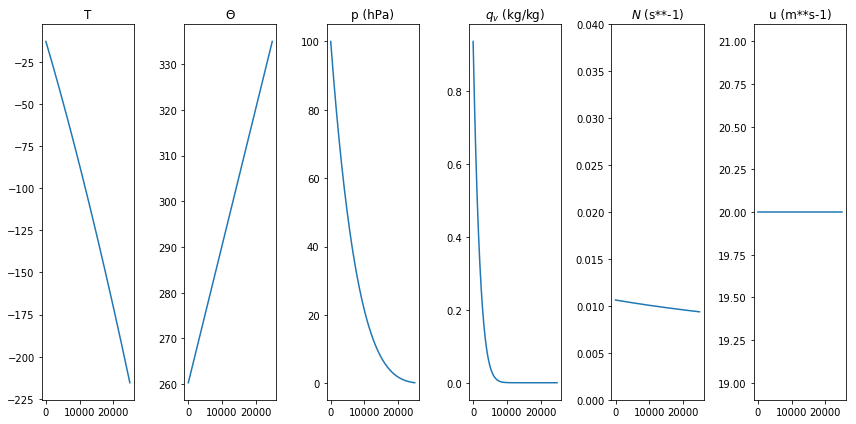

In [79]:
snd_arrs = [
    np.genfromtxt('../cloud_plots/data/external/wrf_out/ethan/dry/input_sounding',skip_header=1),
    #np.genfromtxt('../cloud_plots/data/external/wrf_out/wethans_settings/a0_1000/a1_20000/280_10_0.0095/input_sounding',skip_header=1)
    #np.genfromtxt('./input_sounding_280_10_0.0095_6.7',skip_header=1)
]


f, ax = plt.subplots(1,6,figsize=(12,6))

for snd_arr in snd_arrs:

    z_arr = snd_arr[:,0]
    th_arr = snd_arr[:,1]
    qv_arr = snd_arr[:,2]
    u_arr = snd_arr[:,3]
    v_arr = snd_arr[:,4]
    Nsnd = snd_arr.shape[0]
    p_arr = np.zeros(Nsnd)
    t_arr = np.zeros(Nsnd)

    N_arr = np.zeros(snd_arr.shape[0]-1)
    for n in range(0,snd_arr.shape[0]-1):
        N_arr[n] = np.sqrt(9.81*(np.log(th_arr[n+1])-np.log(th_arr[n]))/(z_arr[n+1]-z_arr[n]))

    p_arr = p_from_th(p0=100000,th_arr=th_arr,z_arr=z_arr)
    t_arr = t_from_tpot(p=p_arr,tpot=th_arr)

    ax[0].plot(z_arr, t_arr-273.15)
    ax[1].plot(z_arr, th_arr)
    ax[2].plot(z_arr, p_arr/1000)
    ax[3].plot(z_arr, qv_arr)
    ax[4].plot(z_arr[:-1], N_arr)
    ax[5].plot(z_arr, u_arr)

    ax[0].set_title('T')
    ax[1].set_title('$\Theta$')
    ax[2].set_title('p (hPa)')
    ax[3].set_title('$q_v$ (kg/kg)')
    ax[4].set_title('$N$ (s**-1)')
    ax[5].set_title('u (m**s-1)')
    


    ax[4].set_ylim(0,0.04)

plt.tight_layout()

In [20]:
th_arr = snd_arrs[1][:,1]
print(th_arr[0])
th_arr[1:]-th_arr[:-1]

288.15


array([0.15, 0.14, 0.15, 0.15, 0.15, 0.14, 0.15, 0.15, 0.15, 0.14, 0.15,
       0.15, 0.15, 0.14, 0.15, 0.15, 0.15, 0.15, 0.14, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.14, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.16, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.16, 0.15, 0.15, 0.15,
       0.15, 0.16, 0.15, 0.15, 0.15, 0.15, 0.16, 0.15, 0.15, 0.15, 0.16,
       0.15, 0.15, 0.16, 0.15, 0.15, 0.16, 0.15, 0.15, 0.16, 0.15, 0.15,
       0.16, 0.15, 0.15, 0.16, 0.15, 0.16, 0.15, 0.15, 0.16, 0.15, 0.16,
       0.15, 0.16, 0.15, 0.16, 0.15, 0.16, 0.15, 0.16, 0.15, 0.16, 0.15,
       0.16, 0.15, 0.16, 0.15, 0.16, 0.16, 0.15, 0.16, 0.15, 0.16, 0.16,
       0.15, 0.16, 0.16, 0.15, 0.16, 0.16, 0.15, 0.16, 0.16, 0.15, 0.16,
       0.16, 0.15, 0.16, 0.16, 0.16, 0.15, 0.16, 0.16, 0.16, 0.16, 0.15,
       0.16, 0.16, 0.16, 0.16, 0.15, 0.16, 0.16, 0.

In [21]:
N_arr

array([0.01010484, 0.00975975, 0.01009976, 0.01009713, 0.01009451,
       0.00974978, 0.01008945, 0.01008683, 0.01008422, 0.00973984,
       0.01007917, 0.01007656, 0.01007395, 0.00972993, 0.01006892,
       0.01006632, 0.01006372, 0.01006112, 0.00971755, 0.01005611,
       0.01005352, 0.01005093, 0.01004834, 0.01004576, 0.01004318,
       0.0100406 , 0.00969773, 0.01003561, 0.01003304, 0.01003046,
       0.01002789, 0.01002533, 0.01002276, 0.01002019, 0.01001763,
       0.01001507, 0.01001251, 0.01000995, 0.0100074 , 0.01000485,
       0.01000229, 0.00999975, 0.0099972 , 0.00999465, 0.00999211,
       0.00998957, 0.00998703, 0.00998449, 0.00998196, 0.00997942,
       0.00997689, 0.00997436, 0.00997183, 0.00996931, 0.00996678,
       0.01029096, 0.00996157, 0.00995905, 0.00995654, 0.00995402,
       0.00995151, 0.009949  , 0.01027261, 0.00994382, 0.00994131,
       0.00993881, 0.00993631, 0.01025951, 0.00993115, 0.00992865,
       0.00992616, 0.00992367, 0.01024646, 0.00991852, 0.00991

In [22]:
N_arr

array([0.01010484, 0.00975975, 0.01009976, 0.01009713, 0.01009451,
       0.00974978, 0.01008945, 0.01008683, 0.01008422, 0.00973984,
       0.01007917, 0.01007656, 0.01007395, 0.00972993, 0.01006892,
       0.01006632, 0.01006372, 0.01006112, 0.00971755, 0.01005611,
       0.01005352, 0.01005093, 0.01004834, 0.01004576, 0.01004318,
       0.0100406 , 0.00969773, 0.01003561, 0.01003304, 0.01003046,
       0.01002789, 0.01002533, 0.01002276, 0.01002019, 0.01001763,
       0.01001507, 0.01001251, 0.01000995, 0.0100074 , 0.01000485,
       0.01000229, 0.00999975, 0.0099972 , 0.00999465, 0.00999211,
       0.00998957, 0.00998703, 0.00998449, 0.00998196, 0.00997942,
       0.00997689, 0.00997436, 0.00997183, 0.00996931, 0.00996678,
       0.01029096, 0.00996157, 0.00995905, 0.00995654, 0.00995402,
       0.00995151, 0.009949  , 0.01027261, 0.00994382, 0.00994131,
       0.00993881, 0.00993631, 0.01025951, 0.00993115, 0.00992865,
       0.00992616, 0.00992367, 0.01024646, 0.00991852, 0.00991

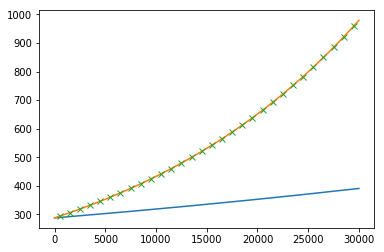

In [94]:
plt.plot(snd_arr[:,0],snd_arr[:,1])
plt.plot(z_arr,th_arr)


In [224]:
frc_ds = xa.open_dataset('../cloud_plots/data/external/downward_extrapolation/rh100/a0_1000m_a1_10000m/advection_modification/cloud_z0_0km_z1_3km/ws25_N0.02/witch_5c1vn1Nff/witch_5c1vn1Nff_nz10/witch_forcing.nc').sel(south_north=3).isel(Time=0)

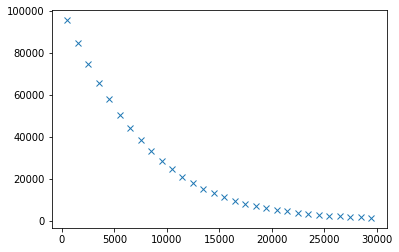

In [225]:
plt.plot(frc_ds['PH'][:,0],frc_ds['P'][:,0],lw=0,marker='x')

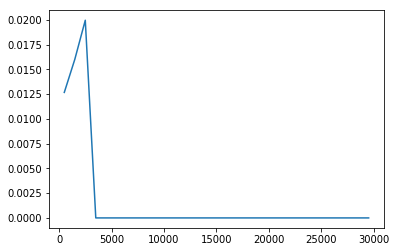

In [226]:
plt.plot(frc_ds['PH'][:,0],frc_ds['QVAPOR'][:,0])

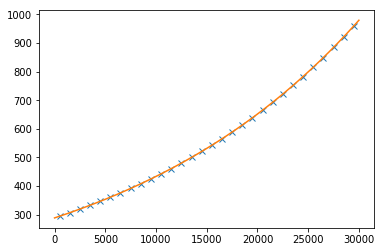

In [230]:
plt.plot(frc_ds['PH'][:,0],frc_ds['T'][:,0],lw=0,marker='x')
plt.plot(z_arr,th_arr)

In [ ]:
#wrfinput to icar input

In [2]:
wrfin_ds = xa.open_dataset('../cloud_plots/data/external/wrf_out/wethans_settings/wet/a0_1000/a1_20000/ICAR/wrfinput_d01')

In [6]:
wrfin_ds.QVAPOR

<xarray.DataArray 'QVAPOR' (Time: 1, bottom_top: 40, south_north: 2, west_east: 401)>
array([[[[2.870002e-03, ..., 2.870002e-03],
         [2.870002e-03, ..., 2.870002e-03]],

        ...,

        [[1.118017e-35, ..., 1.118017e-35],
         [1.118017e-35, ..., 1.118017e-35]]]], dtype=float32)
Coordinates:
    XLAT     (Time, south_north, west_east) float32 0.0 0.0 0.0 0.0 0.0 0.0 ...
    XLONG    (Time, south_north, west_east) float32 0.0 0.0 0.0 0.0 0.0 0.0 ...
Dimensions without coordinates: Time, bottom_top, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  Water vapor mixing ratio
    units:        kg kg-1
    stagger:      
    coordinates:  XLONG XLAT XTIME